In [65]:
hyperparameters = {'subject_tokens': 'hul idk ()',
 'subject_prompt': 'a hul idk () dog',
 'class_prompt': 'a dog',
 'num_prior_images': 1000,
 'learning_rate': 1e-06,
 'num_train_epochs': 1000,
 'prior_batch_size': 5
}

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms

In [2]:
import random

def create_rare_token(tokenizer, num_tokens=3, token_range=(5000, 10000), max_length=3):
    """
    Generates a rare identifier by sampling tokens from the tokenizer's vocabulary.
    
    Args:
        tokenizer: Hugging Face tokenizer (e.g. T5Tokenizer).
        num_tokens: Number of tokens to sample (concatenated in order).
        token_range: Tuple indicating the range of token IDs to consider.
        max_length: Maximum length (in characters) for each decoded token.
    
    Returns:
        A string identifier that is the concatenation of sampled rare tokens.
    """
    candidate_tokens = []
    
    # Iterate through the specified token ID range.
    for token_id in range(token_range[0], token_range[1]):
        token_str = tokenizer.decode([token_id]).strip()
        # Check that the token is non-empty, doesn't contain spaces, and is short.
        if token_str and (" " not in token_str) and (len(token_str) <= max_length):
            candidate_tokens.append(token_str)
    
    if not candidate_tokens:
        raise ValueError("No suitable rare tokens found in the given range.")
    
    # Randomly sample the requested number of tokens and concatenate them.
    selected_tokens = random.choices(candidate_tokens, k=num_tokens)
    rare_identifier = " ".join(selected_tokens)
    return rare_identifier

In [56]:
hyperparameters = {}

In [3]:
# -------------------------------
# 2. Define Tokenizer, Text Encoder and Image Transforms
# -------------------------------
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

In [4]:
# -------------------------------
# 1. Load & Prepare Dataset with DreamBooth Prompts
# -------------------------------
# Set DreamBooth prompt parameters.
use_dreambooth_prompts = True
subject_identifier = create_rare_token(tokenizer)
subject_class = "dog"             # The coarse class (e.g., "dog")
subject_prompt = f"a {subject_identifier} {subject_class}"
class_prompt = f"a {subject_class}"

In [5]:
subject_prompt

'a hul idk () dog'

In [57]:
hyperparameters["subject_tokens"] = subject_identifier
hyperparameters["subject_prompt"] = subject_prompt
hyperparameters["class_prompt"] = class_prompt

In [6]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, subject_prompt, class_prompt, tokenizer, transforms, use_dreambooth_prompts=True):
        self.image_dir = image_dir
        self.subject_prompt = subject_prompt
        self.class_prompt = class_prompt
        self.tokenizer = tokenizer
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms
        self.use_dreambooth_prompts = use_dreambooth_prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        prompt = self.subject_prompt if self.use_dreambooth_prompts else self.class_prompt
        encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.tokenizer.model_max_length, return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

In [8]:
# Usage example
image_dir = '../data/paper_dataset/dog'
use_dreambooth_prompts = True

dataset = CustomDataset(image_dir, subject_prompt, class_prompt, tokenizer, train_transforms,)

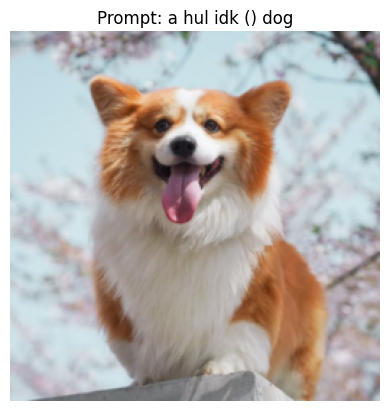

In [34]:
import matplotlib.pyplot as plt
# Function to visualize an image
def visualize_image(dataset, idx):
    image, input_ids, attention_mask = dataset[idx]
    image = image.permute(1, 2, 0)  # Change the order of dimensions for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    image = image.numpy()
    
    plt.imshow(image)
    plt.title(f"Prompt: {dataset.subject_prompt if dataset.use_dreambooth_prompts else dataset.class_prompt}")
    plt.axis('off')
    plt.show()

# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [11]:
train_batch_size = 5
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

In [12]:
# -------------------------------
# 3. Load Pretrained Diffusion Components
# -------------------------------
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [13]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
variant = None

In [14]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

In [17]:
import torch
import subprocess

def get_free_gpu():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    free_memory = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return free_memory.index(max(free_memory))

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [18]:
# -------------------------------
# 5. Set Up Prior Preservation Mechanism
# -------------------------------
use_prior_preservation = True
prior_loss_weight = 1.0  # lambda in the paper

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating prior preservation latents...
Image №0


  0%|          | 0/50 [00:00<?, ?it/s]

Image №1


  0%|          | 0/50 [00:00<?, ?it/s]

Image №2


  0%|          | 0/50 [00:00<?, ?it/s]

Image №3


  0%|          | 0/50 [00:00<?, ?it/s]

Image №4


  0%|          | 0/50 [00:00<?, ?it/s]

Image №5


  0%|          | 0/50 [00:00<?, ?it/s]

Image №6


  0%|          | 0/50 [00:00<?, ?it/s]

Image №7


  0%|          | 0/50 [00:00<?, ?it/s]

Image №8


  0%|          | 0/50 [00:00<?, ?it/s]

Image №9


  0%|          | 0/50 [00:00<?, ?it/s]

Image №10


  0%|          | 0/50 [00:00<?, ?it/s]

Image №11


  0%|          | 0/50 [00:00<?, ?it/s]

Image №12


  0%|          | 0/50 [00:00<?, ?it/s]

Image №13


  0%|          | 0/50 [00:00<?, ?it/s]

Image №14


  0%|          | 0/50 [00:00<?, ?it/s]

Image №15


  0%|          | 0/50 [00:00<?, ?it/s]

Image №16


  0%|          | 0/50 [00:00<?, ?it/s]

Image №17


  0%|          | 0/50 [00:00<?, ?it/s]

Image №18


  0%|          | 0/50 [00:00<?, ?it/s]

Image №19


  0%|          | 0/50 [00:00<?, ?it/s]

Image №20


  0%|          | 0/50 [00:00<?, ?it/s]

Image №21


  0%|          | 0/50 [00:00<?, ?it/s]

Image №22


  0%|          | 0/50 [00:00<?, ?it/s]

Image №23


  0%|          | 0/50 [00:00<?, ?it/s]

Image №24


  0%|          | 0/50 [00:00<?, ?it/s]

Image №25


  0%|          | 0/50 [00:00<?, ?it/s]

Image №26


  0%|          | 0/50 [00:00<?, ?it/s]

Image №27


  0%|          | 0/50 [00:00<?, ?it/s]

Image №28


  0%|          | 0/50 [00:00<?, ?it/s]

Image №29


  0%|          | 0/50 [00:00<?, ?it/s]

Image №30


  0%|          | 0/50 [00:00<?, ?it/s]

Image №31


  0%|          | 0/50 [00:00<?, ?it/s]

Image №32


  0%|          | 0/50 [00:00<?, ?it/s]

Image №33


  0%|          | 0/50 [00:00<?, ?it/s]

Image №34


  0%|          | 0/50 [00:00<?, ?it/s]

Image №35


  0%|          | 0/50 [00:00<?, ?it/s]

Image №36


  0%|          | 0/50 [00:00<?, ?it/s]

Image №37


  0%|          | 0/50 [00:00<?, ?it/s]

Image №38


  0%|          | 0/50 [00:00<?, ?it/s]

Image №39


  0%|          | 0/50 [00:00<?, ?it/s]

Image №40


  0%|          | 0/50 [00:00<?, ?it/s]

Image №41


  0%|          | 0/50 [00:00<?, ?it/s]

Image №42


  0%|          | 0/50 [00:00<?, ?it/s]

Image №43


  0%|          | 0/50 [00:00<?, ?it/s]

Image №44


  0%|          | 0/50 [00:00<?, ?it/s]

Image №45


  0%|          | 0/50 [00:00<?, ?it/s]

Image №46


  0%|          | 0/50 [00:00<?, ?it/s]

Image №47


  0%|          | 0/50 [00:00<?, ?it/s]

Image №48


  0%|          | 0/50 [00:00<?, ?it/s]

Image №49


  0%|          | 0/50 [00:00<?, ?it/s]

Image №50


  0%|          | 0/50 [00:00<?, ?it/s]

Image №51


  0%|          | 0/50 [00:00<?, ?it/s]

Image №52


  0%|          | 0/50 [00:00<?, ?it/s]

Image №53


  0%|          | 0/50 [00:00<?, ?it/s]

Image №54


  0%|          | 0/50 [00:00<?, ?it/s]

Image №55


  0%|          | 0/50 [00:00<?, ?it/s]

Image №56


  0%|          | 0/50 [00:00<?, ?it/s]

Image №57


  0%|          | 0/50 [00:00<?, ?it/s]

Image №58


  0%|          | 0/50 [00:00<?, ?it/s]

Image №59


  0%|          | 0/50 [00:00<?, ?it/s]

Image №60


  0%|          | 0/50 [00:00<?, ?it/s]

Image №61


  0%|          | 0/50 [00:00<?, ?it/s]

Image №62


  0%|          | 0/50 [00:00<?, ?it/s]

Image №63


  0%|          | 0/50 [00:00<?, ?it/s]

Image №64


  0%|          | 0/50 [00:00<?, ?it/s]

Image №65


  0%|          | 0/50 [00:00<?, ?it/s]

Image №66


  0%|          | 0/50 [00:00<?, ?it/s]

Image №67


  0%|          | 0/50 [00:00<?, ?it/s]

Image №68


  0%|          | 0/50 [00:00<?, ?it/s]

Image №69


  0%|          | 0/50 [00:00<?, ?it/s]

Image №70


  0%|          | 0/50 [00:00<?, ?it/s]

Image №71


  0%|          | 0/50 [00:00<?, ?it/s]

Image №72


  0%|          | 0/50 [00:00<?, ?it/s]

Image №73


  0%|          | 0/50 [00:00<?, ?it/s]

Image №74


  0%|          | 0/50 [00:00<?, ?it/s]

Image №75


  0%|          | 0/50 [00:00<?, ?it/s]

Image №76


  0%|          | 0/50 [00:00<?, ?it/s]

Image №77


  0%|          | 0/50 [00:00<?, ?it/s]

Image №78


  0%|          | 0/50 [00:00<?, ?it/s]

Image №79


  0%|          | 0/50 [00:00<?, ?it/s]

Image №80


  0%|          | 0/50 [00:00<?, ?it/s]

Image №81


  0%|          | 0/50 [00:00<?, ?it/s]

Image №82


  0%|          | 0/50 [00:00<?, ?it/s]

Image №83


  0%|          | 0/50 [00:00<?, ?it/s]

Image №84


  0%|          | 0/50 [00:00<?, ?it/s]

Image №85


  0%|          | 0/50 [00:00<?, ?it/s]

Image №86


  0%|          | 0/50 [00:00<?, ?it/s]

Image №87


  0%|          | 0/50 [00:00<?, ?it/s]

Image №88


  0%|          | 0/50 [00:00<?, ?it/s]

Image №89


  0%|          | 0/50 [00:00<?, ?it/s]

Image №90


  0%|          | 0/50 [00:00<?, ?it/s]

Image №91


  0%|          | 0/50 [00:00<?, ?it/s]

Image №92


  0%|          | 0/50 [00:00<?, ?it/s]

Image №93


  0%|          | 0/50 [00:00<?, ?it/s]

Image №94


  0%|          | 0/50 [00:00<?, ?it/s]

Image №95


  0%|          | 0/50 [00:00<?, ?it/s]

Image №96


  0%|          | 0/50 [00:00<?, ?it/s]

Image №97


  0%|          | 0/50 [00:00<?, ?it/s]

Image №98


  0%|          | 0/50 [00:00<?, ?it/s]

Image №99


  0%|          | 0/50 [00:00<?, ?it/s]

Image №100


  0%|          | 0/50 [00:00<?, ?it/s]

Image №101


  0%|          | 0/50 [00:00<?, ?it/s]

Image №102


  0%|          | 0/50 [00:00<?, ?it/s]

Image №103


  0%|          | 0/50 [00:00<?, ?it/s]

Image №104


  0%|          | 0/50 [00:00<?, ?it/s]

Image №105


  0%|          | 0/50 [00:00<?, ?it/s]

Image №106


  0%|          | 0/50 [00:00<?, ?it/s]

Image №107


  0%|          | 0/50 [00:00<?, ?it/s]

Image №108


  0%|          | 0/50 [00:00<?, ?it/s]

Image №109


  0%|          | 0/50 [00:00<?, ?it/s]

Image №110


  0%|          | 0/50 [00:00<?, ?it/s]

Image №111


  0%|          | 0/50 [00:00<?, ?it/s]

Image №112


  0%|          | 0/50 [00:00<?, ?it/s]

Image №113


  0%|          | 0/50 [00:00<?, ?it/s]

Image №114


  0%|          | 0/50 [00:00<?, ?it/s]

Image №115


  0%|          | 0/50 [00:00<?, ?it/s]

Image №116


  0%|          | 0/50 [00:00<?, ?it/s]

Image №117


  0%|          | 0/50 [00:00<?, ?it/s]

Image №118


  0%|          | 0/50 [00:00<?, ?it/s]

Image №119


  0%|          | 0/50 [00:00<?, ?it/s]

Image №120


  0%|          | 0/50 [00:00<?, ?it/s]

Image №121


  0%|          | 0/50 [00:00<?, ?it/s]

Image №122


  0%|          | 0/50 [00:00<?, ?it/s]

Image №123


  0%|          | 0/50 [00:00<?, ?it/s]

Image №124


  0%|          | 0/50 [00:00<?, ?it/s]

Image №125


  0%|          | 0/50 [00:00<?, ?it/s]

Image №126


  0%|          | 0/50 [00:00<?, ?it/s]

Image №127


  0%|          | 0/50 [00:00<?, ?it/s]

Image №128


  0%|          | 0/50 [00:00<?, ?it/s]

Image №129


  0%|          | 0/50 [00:00<?, ?it/s]

Image №130


  0%|          | 0/50 [00:00<?, ?it/s]

Image №131


  0%|          | 0/50 [00:00<?, ?it/s]

Image №132


  0%|          | 0/50 [00:00<?, ?it/s]

Image №133


  0%|          | 0/50 [00:00<?, ?it/s]

Image №134


  0%|          | 0/50 [00:00<?, ?it/s]

Image №135


  0%|          | 0/50 [00:00<?, ?it/s]

Image №136


  0%|          | 0/50 [00:00<?, ?it/s]

Image №137


  0%|          | 0/50 [00:00<?, ?it/s]

Image №138


  0%|          | 0/50 [00:00<?, ?it/s]

Image №139


  0%|          | 0/50 [00:00<?, ?it/s]

Image №140


  0%|          | 0/50 [00:00<?, ?it/s]

Image №141


  0%|          | 0/50 [00:00<?, ?it/s]

Image №142


  0%|          | 0/50 [00:00<?, ?it/s]

Image №143


  0%|          | 0/50 [00:00<?, ?it/s]

Image №144


  0%|          | 0/50 [00:00<?, ?it/s]

Image №145


  0%|          | 0/50 [00:00<?, ?it/s]

Image №146


  0%|          | 0/50 [00:00<?, ?it/s]

Image №147


  0%|          | 0/50 [00:00<?, ?it/s]

Image №148


  0%|          | 0/50 [00:00<?, ?it/s]

Image №149


  0%|          | 0/50 [00:00<?, ?it/s]

Image №150


  0%|          | 0/50 [00:00<?, ?it/s]

Image №151


  0%|          | 0/50 [00:00<?, ?it/s]

Image №152


  0%|          | 0/50 [00:00<?, ?it/s]

Image №153


  0%|          | 0/50 [00:00<?, ?it/s]

Image №154


  0%|          | 0/50 [00:00<?, ?it/s]

Image №155


  0%|          | 0/50 [00:00<?, ?it/s]

Image №156


  0%|          | 0/50 [00:00<?, ?it/s]

Image №157


  0%|          | 0/50 [00:00<?, ?it/s]

Image №158


  0%|          | 0/50 [00:00<?, ?it/s]

Image №159


  0%|          | 0/50 [00:00<?, ?it/s]

Image №160


  0%|          | 0/50 [00:00<?, ?it/s]

Image №161


  0%|          | 0/50 [00:00<?, ?it/s]

Image №162


  0%|          | 0/50 [00:00<?, ?it/s]

Image №163


  0%|          | 0/50 [00:00<?, ?it/s]

Image №164


  0%|          | 0/50 [00:00<?, ?it/s]

Image №165


  0%|          | 0/50 [00:00<?, ?it/s]

Image №166


  0%|          | 0/50 [00:00<?, ?it/s]

Image №167


  0%|          | 0/50 [00:00<?, ?it/s]

Image №168


  0%|          | 0/50 [00:00<?, ?it/s]

Image №169


  0%|          | 0/50 [00:00<?, ?it/s]

Image №170


  0%|          | 0/50 [00:00<?, ?it/s]

Image №171


  0%|          | 0/50 [00:00<?, ?it/s]

Image №172


  0%|          | 0/50 [00:00<?, ?it/s]

Image №173


  0%|          | 0/50 [00:00<?, ?it/s]

Image №174


  0%|          | 0/50 [00:00<?, ?it/s]

Image №175


  0%|          | 0/50 [00:00<?, ?it/s]

Image №176


  0%|          | 0/50 [00:00<?, ?it/s]

Image №177


  0%|          | 0/50 [00:00<?, ?it/s]

Image №178


  0%|          | 0/50 [00:00<?, ?it/s]

Image №179


  0%|          | 0/50 [00:00<?, ?it/s]

Image №180


  0%|          | 0/50 [00:00<?, ?it/s]

Image №181


  0%|          | 0/50 [00:00<?, ?it/s]

Image №182


  0%|          | 0/50 [00:00<?, ?it/s]

Image №183


  0%|          | 0/50 [00:00<?, ?it/s]

Image №184


  0%|          | 0/50 [00:00<?, ?it/s]

Image №185


  0%|          | 0/50 [00:00<?, ?it/s]

Image №186


  0%|          | 0/50 [00:00<?, ?it/s]

Image №187


  0%|          | 0/50 [00:00<?, ?it/s]

Image №188


  0%|          | 0/50 [00:00<?, ?it/s]

Image №189


  0%|          | 0/50 [00:00<?, ?it/s]

Image №190


  0%|          | 0/50 [00:00<?, ?it/s]

Image №191


  0%|          | 0/50 [00:00<?, ?it/s]

Image №192


  0%|          | 0/50 [00:00<?, ?it/s]

Image №193


  0%|          | 0/50 [00:00<?, ?it/s]

Image №194


  0%|          | 0/50 [00:00<?, ?it/s]

Image №195


  0%|          | 0/50 [00:00<?, ?it/s]

Image №196


  0%|          | 0/50 [00:00<?, ?it/s]

Image №197


  0%|          | 0/50 [00:00<?, ?it/s]

Image №198


  0%|          | 0/50 [00:00<?, ?it/s]

Image №199


  0%|          | 0/50 [00:00<?, ?it/s]

Image №200


  0%|          | 0/50 [00:00<?, ?it/s]

Image №201


  0%|          | 0/50 [00:00<?, ?it/s]

Image №202


  0%|          | 0/50 [00:00<?, ?it/s]

Image №203


  0%|          | 0/50 [00:00<?, ?it/s]

Image №204


  0%|          | 0/50 [00:00<?, ?it/s]

Image №205


  0%|          | 0/50 [00:00<?, ?it/s]

Image №206


  0%|          | 0/50 [00:00<?, ?it/s]

Image №207


  0%|          | 0/50 [00:00<?, ?it/s]

Image №208


  0%|          | 0/50 [00:00<?, ?it/s]

Image №209


  0%|          | 0/50 [00:00<?, ?it/s]

Image №210


  0%|          | 0/50 [00:00<?, ?it/s]

Image №211


  0%|          | 0/50 [00:00<?, ?it/s]

Image №212


  0%|          | 0/50 [00:00<?, ?it/s]

Image №213


  0%|          | 0/50 [00:00<?, ?it/s]

Image №214


  0%|          | 0/50 [00:00<?, ?it/s]

Image №215


  0%|          | 0/50 [00:00<?, ?it/s]

Image №216


  0%|          | 0/50 [00:00<?, ?it/s]

Image №217


  0%|          | 0/50 [00:00<?, ?it/s]

Image №218


  0%|          | 0/50 [00:00<?, ?it/s]

Image №219


  0%|          | 0/50 [00:00<?, ?it/s]

Image №220


  0%|          | 0/50 [00:00<?, ?it/s]

Image №221


  0%|          | 0/50 [00:00<?, ?it/s]

Image №222


  0%|          | 0/50 [00:00<?, ?it/s]

Image №223


  0%|          | 0/50 [00:00<?, ?it/s]

Image №224


  0%|          | 0/50 [00:00<?, ?it/s]

Image №225


  0%|          | 0/50 [00:00<?, ?it/s]

Image №226


  0%|          | 0/50 [00:00<?, ?it/s]

Image №227


  0%|          | 0/50 [00:00<?, ?it/s]

Image №228


  0%|          | 0/50 [00:00<?, ?it/s]

Image №229


  0%|          | 0/50 [00:00<?, ?it/s]

Image №230


  0%|          | 0/50 [00:00<?, ?it/s]

Image №231


  0%|          | 0/50 [00:00<?, ?it/s]

Image №232


  0%|          | 0/50 [00:00<?, ?it/s]

Image №233


  0%|          | 0/50 [00:00<?, ?it/s]

Image №234


  0%|          | 0/50 [00:00<?, ?it/s]

Image №235


  0%|          | 0/50 [00:00<?, ?it/s]

Image №236


  0%|          | 0/50 [00:00<?, ?it/s]

Image №237


  0%|          | 0/50 [00:00<?, ?it/s]

Image №238


  0%|          | 0/50 [00:00<?, ?it/s]

Image №239


  0%|          | 0/50 [00:00<?, ?it/s]

Image №240


  0%|          | 0/50 [00:00<?, ?it/s]

Image №241


  0%|          | 0/50 [00:00<?, ?it/s]

Image №242


  0%|          | 0/50 [00:00<?, ?it/s]

Image №243


  0%|          | 0/50 [00:00<?, ?it/s]

Image №244


  0%|          | 0/50 [00:00<?, ?it/s]

Image №245


  0%|          | 0/50 [00:00<?, ?it/s]

Image №246


  0%|          | 0/50 [00:00<?, ?it/s]

Image №247


  0%|          | 0/50 [00:00<?, ?it/s]

Image №248


  0%|          | 0/50 [00:00<?, ?it/s]

Image №249


  0%|          | 0/50 [00:00<?, ?it/s]

Image №250


  0%|          | 0/50 [00:00<?, ?it/s]

Image №251


  0%|          | 0/50 [00:00<?, ?it/s]

Image №252


  0%|          | 0/50 [00:00<?, ?it/s]

Image №253


  0%|          | 0/50 [00:00<?, ?it/s]

Image №254


  0%|          | 0/50 [00:00<?, ?it/s]

Image №255


  0%|          | 0/50 [00:00<?, ?it/s]

Image №256


  0%|          | 0/50 [00:00<?, ?it/s]

Image №257


  0%|          | 0/50 [00:00<?, ?it/s]

Image №258


  0%|          | 0/50 [00:00<?, ?it/s]

Image №259


  0%|          | 0/50 [00:00<?, ?it/s]

Image №260


  0%|          | 0/50 [00:00<?, ?it/s]

Image №261


  0%|          | 0/50 [00:00<?, ?it/s]

Image №262


  0%|          | 0/50 [00:00<?, ?it/s]

Image №263


  0%|          | 0/50 [00:00<?, ?it/s]

Image №264


  0%|          | 0/50 [00:00<?, ?it/s]

Image №265


  0%|          | 0/50 [00:00<?, ?it/s]

Image №266


  0%|          | 0/50 [00:00<?, ?it/s]

Image №267


  0%|          | 0/50 [00:00<?, ?it/s]

Image №268


  0%|          | 0/50 [00:00<?, ?it/s]

Image №269


  0%|          | 0/50 [00:00<?, ?it/s]

Image №270


  0%|          | 0/50 [00:00<?, ?it/s]

Image №271


  0%|          | 0/50 [00:00<?, ?it/s]

Image №272


  0%|          | 0/50 [00:00<?, ?it/s]

Image №273


  0%|          | 0/50 [00:00<?, ?it/s]

Image №274


  0%|          | 0/50 [00:00<?, ?it/s]

Image №275


  0%|          | 0/50 [00:00<?, ?it/s]

Image №276


  0%|          | 0/50 [00:00<?, ?it/s]

Image №277


  0%|          | 0/50 [00:00<?, ?it/s]

Image №278


  0%|          | 0/50 [00:00<?, ?it/s]

Image №279


  0%|          | 0/50 [00:00<?, ?it/s]

Image №280


  0%|          | 0/50 [00:00<?, ?it/s]

Image №281


  0%|          | 0/50 [00:00<?, ?it/s]

Image №282


  0%|          | 0/50 [00:00<?, ?it/s]

Image №283


  0%|          | 0/50 [00:00<?, ?it/s]

Image №284


  0%|          | 0/50 [00:00<?, ?it/s]

Image №285


  0%|          | 0/50 [00:00<?, ?it/s]

Image №286


  0%|          | 0/50 [00:00<?, ?it/s]

Image №287


  0%|          | 0/50 [00:00<?, ?it/s]

Image №288


  0%|          | 0/50 [00:00<?, ?it/s]

Image №289


  0%|          | 0/50 [00:00<?, ?it/s]

Image №290


  0%|          | 0/50 [00:00<?, ?it/s]

Image №291


  0%|          | 0/50 [00:00<?, ?it/s]

Image №292


  0%|          | 0/50 [00:00<?, ?it/s]

Image №293


  0%|          | 0/50 [00:00<?, ?it/s]

Image №294


  0%|          | 0/50 [00:00<?, ?it/s]

Image №295


  0%|          | 0/50 [00:00<?, ?it/s]

Image №296


  0%|          | 0/50 [00:00<?, ?it/s]

Image №297


  0%|          | 0/50 [00:00<?, ?it/s]

Image №298


  0%|          | 0/50 [00:00<?, ?it/s]

Image №299


  0%|          | 0/50 [00:00<?, ?it/s]

Image №300


  0%|          | 0/50 [00:00<?, ?it/s]

Image №301


  0%|          | 0/50 [00:00<?, ?it/s]

Image №302


  0%|          | 0/50 [00:00<?, ?it/s]

Image №303


  0%|          | 0/50 [00:00<?, ?it/s]

Image №304


  0%|          | 0/50 [00:00<?, ?it/s]

Image №305


  0%|          | 0/50 [00:00<?, ?it/s]

Image №306


  0%|          | 0/50 [00:00<?, ?it/s]

Image №307


  0%|          | 0/50 [00:00<?, ?it/s]

Image №308


  0%|          | 0/50 [00:00<?, ?it/s]

Image №309


  0%|          | 0/50 [00:00<?, ?it/s]

Image №310


  0%|          | 0/50 [00:00<?, ?it/s]

Image №311


  0%|          | 0/50 [00:00<?, ?it/s]

Image №312


  0%|          | 0/50 [00:00<?, ?it/s]

Image №313


  0%|          | 0/50 [00:00<?, ?it/s]

Image №314


  0%|          | 0/50 [00:00<?, ?it/s]

Image №315


  0%|          | 0/50 [00:00<?, ?it/s]

Image №316


  0%|          | 0/50 [00:00<?, ?it/s]

Image №317


  0%|          | 0/50 [00:00<?, ?it/s]

Image №318


  0%|          | 0/50 [00:00<?, ?it/s]

Image №319


  0%|          | 0/50 [00:00<?, ?it/s]

Image №320


  0%|          | 0/50 [00:00<?, ?it/s]

Image №321


  0%|          | 0/50 [00:00<?, ?it/s]

Image №322


  0%|          | 0/50 [00:00<?, ?it/s]

Image №323


  0%|          | 0/50 [00:00<?, ?it/s]

Image №324


  0%|          | 0/50 [00:00<?, ?it/s]

Image №325


  0%|          | 0/50 [00:00<?, ?it/s]

Image №326


  0%|          | 0/50 [00:00<?, ?it/s]

Image №327


  0%|          | 0/50 [00:00<?, ?it/s]

Image №328


  0%|          | 0/50 [00:00<?, ?it/s]

Image №329


  0%|          | 0/50 [00:00<?, ?it/s]

Image №330


  0%|          | 0/50 [00:00<?, ?it/s]

Image №331


  0%|          | 0/50 [00:00<?, ?it/s]

Image №332


  0%|          | 0/50 [00:00<?, ?it/s]

Image №333


  0%|          | 0/50 [00:00<?, ?it/s]

Image №334


  0%|          | 0/50 [00:00<?, ?it/s]

Image №335


  0%|          | 0/50 [00:00<?, ?it/s]

Image №336


  0%|          | 0/50 [00:00<?, ?it/s]

Image №337


  0%|          | 0/50 [00:00<?, ?it/s]

Image №338


  0%|          | 0/50 [00:00<?, ?it/s]

Image №339


  0%|          | 0/50 [00:00<?, ?it/s]

Image №340


  0%|          | 0/50 [00:00<?, ?it/s]

Image №341


  0%|          | 0/50 [00:00<?, ?it/s]

Image №342


  0%|          | 0/50 [00:00<?, ?it/s]

Image №343


  0%|          | 0/50 [00:00<?, ?it/s]

Image №344


  0%|          | 0/50 [00:00<?, ?it/s]

Image №345


  0%|          | 0/50 [00:00<?, ?it/s]

Image №346


  0%|          | 0/50 [00:00<?, ?it/s]

Image №347


  0%|          | 0/50 [00:00<?, ?it/s]

Image №348


  0%|          | 0/50 [00:00<?, ?it/s]

Image №349


  0%|          | 0/50 [00:00<?, ?it/s]

Image №350


  0%|          | 0/50 [00:00<?, ?it/s]

Image №351


  0%|          | 0/50 [00:00<?, ?it/s]

Image №352


  0%|          | 0/50 [00:00<?, ?it/s]

Image №353


  0%|          | 0/50 [00:00<?, ?it/s]

Image №354


  0%|          | 0/50 [00:00<?, ?it/s]

Image №355


  0%|          | 0/50 [00:00<?, ?it/s]

Image №356


  0%|          | 0/50 [00:00<?, ?it/s]

Image №357


  0%|          | 0/50 [00:00<?, ?it/s]

Image №358


  0%|          | 0/50 [00:00<?, ?it/s]

Image №359


  0%|          | 0/50 [00:00<?, ?it/s]

Image №360


  0%|          | 0/50 [00:00<?, ?it/s]

Image №361


  0%|          | 0/50 [00:00<?, ?it/s]

Image №362


  0%|          | 0/50 [00:00<?, ?it/s]

Image №363


  0%|          | 0/50 [00:00<?, ?it/s]

Image №364


  0%|          | 0/50 [00:00<?, ?it/s]

Image №365


  0%|          | 0/50 [00:00<?, ?it/s]

Image №366


  0%|          | 0/50 [00:00<?, ?it/s]

Image №367


  0%|          | 0/50 [00:00<?, ?it/s]

Image №368


  0%|          | 0/50 [00:00<?, ?it/s]

Image №369


  0%|          | 0/50 [00:00<?, ?it/s]

Image №370


  0%|          | 0/50 [00:00<?, ?it/s]

Image №371


  0%|          | 0/50 [00:00<?, ?it/s]

Image №372


  0%|          | 0/50 [00:00<?, ?it/s]

Image №373


  0%|          | 0/50 [00:00<?, ?it/s]

Image №374


  0%|          | 0/50 [00:00<?, ?it/s]

Image №375


  0%|          | 0/50 [00:00<?, ?it/s]

Image №376


  0%|          | 0/50 [00:00<?, ?it/s]

Image №377


  0%|          | 0/50 [00:00<?, ?it/s]

Image №378


  0%|          | 0/50 [00:00<?, ?it/s]

Image №379


  0%|          | 0/50 [00:00<?, ?it/s]

Image №380


  0%|          | 0/50 [00:00<?, ?it/s]

Image №381


  0%|          | 0/50 [00:00<?, ?it/s]

Image №382


  0%|          | 0/50 [00:00<?, ?it/s]

Image №383


  0%|          | 0/50 [00:00<?, ?it/s]

Image №384


  0%|          | 0/50 [00:00<?, ?it/s]

Image №385


  0%|          | 0/50 [00:00<?, ?it/s]

Image №386


  0%|          | 0/50 [00:00<?, ?it/s]

Image №387


  0%|          | 0/50 [00:00<?, ?it/s]

Image №388


  0%|          | 0/50 [00:00<?, ?it/s]

Image №389


  0%|          | 0/50 [00:00<?, ?it/s]

Image №390


  0%|          | 0/50 [00:00<?, ?it/s]

Image №391


  0%|          | 0/50 [00:00<?, ?it/s]

Image №392


  0%|          | 0/50 [00:00<?, ?it/s]

Image №393


  0%|          | 0/50 [00:00<?, ?it/s]

Image №394


  0%|          | 0/50 [00:00<?, ?it/s]

Image №395


  0%|          | 0/50 [00:00<?, ?it/s]

Image №396


  0%|          | 0/50 [00:00<?, ?it/s]

Image №397


  0%|          | 0/50 [00:00<?, ?it/s]

Image №398


  0%|          | 0/50 [00:00<?, ?it/s]

Image №399


  0%|          | 0/50 [00:00<?, ?it/s]

Image №400


  0%|          | 0/50 [00:00<?, ?it/s]

Image №401


  0%|          | 0/50 [00:00<?, ?it/s]

Image №402


  0%|          | 0/50 [00:00<?, ?it/s]

Image №403


  0%|          | 0/50 [00:00<?, ?it/s]

Image №404


  0%|          | 0/50 [00:00<?, ?it/s]

Image №405


  0%|          | 0/50 [00:00<?, ?it/s]

Image №406


  0%|          | 0/50 [00:00<?, ?it/s]

Image №407


  0%|          | 0/50 [00:00<?, ?it/s]

Image №408


  0%|          | 0/50 [00:00<?, ?it/s]

Image №409


  0%|          | 0/50 [00:00<?, ?it/s]

Image №410


  0%|          | 0/50 [00:00<?, ?it/s]

Image №411


  0%|          | 0/50 [00:00<?, ?it/s]

Image №412


  0%|          | 0/50 [00:00<?, ?it/s]

Image №413


  0%|          | 0/50 [00:00<?, ?it/s]

Image №414


  0%|          | 0/50 [00:00<?, ?it/s]

Image №415


  0%|          | 0/50 [00:00<?, ?it/s]

Image №416


  0%|          | 0/50 [00:00<?, ?it/s]

Image №417


  0%|          | 0/50 [00:00<?, ?it/s]

Image №418


  0%|          | 0/50 [00:00<?, ?it/s]

Image №419


  0%|          | 0/50 [00:00<?, ?it/s]

Image №420


  0%|          | 0/50 [00:00<?, ?it/s]

Image №421


  0%|          | 0/50 [00:00<?, ?it/s]

Image №422


  0%|          | 0/50 [00:00<?, ?it/s]

Image №423


  0%|          | 0/50 [00:00<?, ?it/s]

Image №424


  0%|          | 0/50 [00:00<?, ?it/s]

Image №425


  0%|          | 0/50 [00:00<?, ?it/s]

Image №426


  0%|          | 0/50 [00:00<?, ?it/s]

Image №427


  0%|          | 0/50 [00:00<?, ?it/s]

Image №428


  0%|          | 0/50 [00:00<?, ?it/s]

Image №429


  0%|          | 0/50 [00:00<?, ?it/s]

Image №430


  0%|          | 0/50 [00:00<?, ?it/s]

Image №431


  0%|          | 0/50 [00:00<?, ?it/s]

Image №432


  0%|          | 0/50 [00:00<?, ?it/s]

Image №433


  0%|          | 0/50 [00:00<?, ?it/s]

Image №434


  0%|          | 0/50 [00:00<?, ?it/s]

Image №435


  0%|          | 0/50 [00:00<?, ?it/s]

Image №436


  0%|          | 0/50 [00:00<?, ?it/s]

Image №437


  0%|          | 0/50 [00:00<?, ?it/s]

Image №438


  0%|          | 0/50 [00:00<?, ?it/s]

Image №439


  0%|          | 0/50 [00:00<?, ?it/s]

Image №440


  0%|          | 0/50 [00:00<?, ?it/s]

Image №441


  0%|          | 0/50 [00:00<?, ?it/s]

Image №442


  0%|          | 0/50 [00:00<?, ?it/s]

Image №443


  0%|          | 0/50 [00:00<?, ?it/s]

Image №444


  0%|          | 0/50 [00:00<?, ?it/s]

Image №445


  0%|          | 0/50 [00:00<?, ?it/s]

Image №446


  0%|          | 0/50 [00:00<?, ?it/s]

Image №447


  0%|          | 0/50 [00:00<?, ?it/s]

Image №448


  0%|          | 0/50 [00:00<?, ?it/s]

Image №449


  0%|          | 0/50 [00:00<?, ?it/s]

Image №450


  0%|          | 0/50 [00:00<?, ?it/s]

Image №451


  0%|          | 0/50 [00:00<?, ?it/s]

Image №452


  0%|          | 0/50 [00:00<?, ?it/s]

Image №453


  0%|          | 0/50 [00:00<?, ?it/s]

Image №454


  0%|          | 0/50 [00:00<?, ?it/s]

Image №455


  0%|          | 0/50 [00:00<?, ?it/s]

Image №456


  0%|          | 0/50 [00:00<?, ?it/s]

Image №457


  0%|          | 0/50 [00:00<?, ?it/s]

Image №458


  0%|          | 0/50 [00:00<?, ?it/s]

Image №459


  0%|          | 0/50 [00:00<?, ?it/s]

Image №460


  0%|          | 0/50 [00:00<?, ?it/s]

Image №461


  0%|          | 0/50 [00:00<?, ?it/s]

Image №462


  0%|          | 0/50 [00:00<?, ?it/s]

Image №463


  0%|          | 0/50 [00:00<?, ?it/s]

Image №464


  0%|          | 0/50 [00:00<?, ?it/s]

Image №465


  0%|          | 0/50 [00:00<?, ?it/s]

Image №466


  0%|          | 0/50 [00:00<?, ?it/s]

Image №467


  0%|          | 0/50 [00:00<?, ?it/s]

Image №468


  0%|          | 0/50 [00:00<?, ?it/s]

Image №469


  0%|          | 0/50 [00:00<?, ?it/s]

Image №470


  0%|          | 0/50 [00:00<?, ?it/s]

Image №471


  0%|          | 0/50 [00:00<?, ?it/s]

Image №472


  0%|          | 0/50 [00:00<?, ?it/s]

Image №473


  0%|          | 0/50 [00:00<?, ?it/s]

Image №474


  0%|          | 0/50 [00:00<?, ?it/s]

Image №475


  0%|          | 0/50 [00:00<?, ?it/s]

Image №476


  0%|          | 0/50 [00:00<?, ?it/s]

Image №477


  0%|          | 0/50 [00:00<?, ?it/s]

Image №478


  0%|          | 0/50 [00:00<?, ?it/s]

Image №479


  0%|          | 0/50 [00:00<?, ?it/s]

Image №480


  0%|          | 0/50 [00:00<?, ?it/s]

Image №481


  0%|          | 0/50 [00:00<?, ?it/s]

Image №482


  0%|          | 0/50 [00:00<?, ?it/s]

Image №483


  0%|          | 0/50 [00:00<?, ?it/s]

Image №484


  0%|          | 0/50 [00:00<?, ?it/s]

Image №485


  0%|          | 0/50 [00:00<?, ?it/s]

Image №486


  0%|          | 0/50 [00:00<?, ?it/s]

Image №487


  0%|          | 0/50 [00:00<?, ?it/s]

Image №488


  0%|          | 0/50 [00:00<?, ?it/s]

Image №489


  0%|          | 0/50 [00:00<?, ?it/s]

Image №490


  0%|          | 0/50 [00:00<?, ?it/s]

Image №491


  0%|          | 0/50 [00:00<?, ?it/s]

Image №492


  0%|          | 0/50 [00:00<?, ?it/s]

Image №493


  0%|          | 0/50 [00:00<?, ?it/s]

Image №494


  0%|          | 0/50 [00:00<?, ?it/s]

Image №495


  0%|          | 0/50 [00:00<?, ?it/s]

Image №496


  0%|          | 0/50 [00:00<?, ?it/s]

Image №497


  0%|          | 0/50 [00:00<?, ?it/s]

Image №498


  0%|          | 0/50 [00:00<?, ?it/s]

Image №499


  0%|          | 0/50 [00:00<?, ?it/s]

Image №500


  0%|          | 0/50 [00:00<?, ?it/s]

Image №501


  0%|          | 0/50 [00:00<?, ?it/s]

Image №502


  0%|          | 0/50 [00:00<?, ?it/s]

Image №503


  0%|          | 0/50 [00:00<?, ?it/s]

Image №504


  0%|          | 0/50 [00:00<?, ?it/s]

Image №505


  0%|          | 0/50 [00:00<?, ?it/s]

Image №506


  0%|          | 0/50 [00:00<?, ?it/s]

Image №507


  0%|          | 0/50 [00:00<?, ?it/s]

Image №508


  0%|          | 0/50 [00:00<?, ?it/s]

Image №509


  0%|          | 0/50 [00:00<?, ?it/s]

Image №510


  0%|          | 0/50 [00:00<?, ?it/s]

Image №511


  0%|          | 0/50 [00:00<?, ?it/s]

Image №512


  0%|          | 0/50 [00:00<?, ?it/s]

Image №513


  0%|          | 0/50 [00:00<?, ?it/s]

Image №514


  0%|          | 0/50 [00:00<?, ?it/s]

Image №515


  0%|          | 0/50 [00:00<?, ?it/s]

Image №516


  0%|          | 0/50 [00:00<?, ?it/s]

Image №517


  0%|          | 0/50 [00:00<?, ?it/s]

Image №518


  0%|          | 0/50 [00:00<?, ?it/s]

Image №519


  0%|          | 0/50 [00:00<?, ?it/s]

Image №520


  0%|          | 0/50 [00:00<?, ?it/s]

Image №521


  0%|          | 0/50 [00:00<?, ?it/s]

Image №522


  0%|          | 0/50 [00:00<?, ?it/s]

Image №523


  0%|          | 0/50 [00:00<?, ?it/s]

Image №524


  0%|          | 0/50 [00:00<?, ?it/s]

Image №525


  0%|          | 0/50 [00:00<?, ?it/s]

Image №526


  0%|          | 0/50 [00:00<?, ?it/s]

Image №527


  0%|          | 0/50 [00:00<?, ?it/s]

Image №528


  0%|          | 0/50 [00:00<?, ?it/s]

Image №529


  0%|          | 0/50 [00:00<?, ?it/s]

Image №530


  0%|          | 0/50 [00:00<?, ?it/s]

Image №531


  0%|          | 0/50 [00:00<?, ?it/s]

Image №532


  0%|          | 0/50 [00:00<?, ?it/s]

Image №533


  0%|          | 0/50 [00:00<?, ?it/s]

Image №534


  0%|          | 0/50 [00:00<?, ?it/s]

Image №535


  0%|          | 0/50 [00:00<?, ?it/s]

Image №536


  0%|          | 0/50 [00:00<?, ?it/s]

Image №537


  0%|          | 0/50 [00:00<?, ?it/s]

Image №538


  0%|          | 0/50 [00:00<?, ?it/s]

Image №539


  0%|          | 0/50 [00:00<?, ?it/s]

Image №540


  0%|          | 0/50 [00:00<?, ?it/s]

Image №541


  0%|          | 0/50 [00:00<?, ?it/s]

Image №542


  0%|          | 0/50 [00:00<?, ?it/s]

Image №543


  0%|          | 0/50 [00:00<?, ?it/s]

Image №544


  0%|          | 0/50 [00:00<?, ?it/s]

Image №545


  0%|          | 0/50 [00:00<?, ?it/s]

Image №546


  0%|          | 0/50 [00:00<?, ?it/s]

Image №547


  0%|          | 0/50 [00:00<?, ?it/s]

Image №548


  0%|          | 0/50 [00:00<?, ?it/s]

Image №549


  0%|          | 0/50 [00:00<?, ?it/s]

Image №550


  0%|          | 0/50 [00:00<?, ?it/s]

Image №551


  0%|          | 0/50 [00:00<?, ?it/s]

Image №552


  0%|          | 0/50 [00:00<?, ?it/s]

Image №553


  0%|          | 0/50 [00:00<?, ?it/s]

Image №554


  0%|          | 0/50 [00:00<?, ?it/s]

Image №555


  0%|          | 0/50 [00:00<?, ?it/s]

Image №556


  0%|          | 0/50 [00:00<?, ?it/s]

Image №557


  0%|          | 0/50 [00:00<?, ?it/s]

Image №558


  0%|          | 0/50 [00:00<?, ?it/s]

Image №559


  0%|          | 0/50 [00:00<?, ?it/s]

Image №560


  0%|          | 0/50 [00:00<?, ?it/s]

Image №561


  0%|          | 0/50 [00:00<?, ?it/s]

Image №562


  0%|          | 0/50 [00:00<?, ?it/s]

Image №563


  0%|          | 0/50 [00:00<?, ?it/s]

Image №564


  0%|          | 0/50 [00:00<?, ?it/s]

Image №565


  0%|          | 0/50 [00:00<?, ?it/s]

Image №566


  0%|          | 0/50 [00:00<?, ?it/s]

Image №567


  0%|          | 0/50 [00:00<?, ?it/s]

Image №568


  0%|          | 0/50 [00:00<?, ?it/s]

Image №569


  0%|          | 0/50 [00:00<?, ?it/s]

Image №570


  0%|          | 0/50 [00:00<?, ?it/s]

Image №571


  0%|          | 0/50 [00:00<?, ?it/s]

Image №572


  0%|          | 0/50 [00:00<?, ?it/s]

Image №573


  0%|          | 0/50 [00:00<?, ?it/s]

Image №574


  0%|          | 0/50 [00:00<?, ?it/s]

Image №575


  0%|          | 0/50 [00:00<?, ?it/s]

Image №576


  0%|          | 0/50 [00:00<?, ?it/s]

Image №577


  0%|          | 0/50 [00:00<?, ?it/s]

Image №578


  0%|          | 0/50 [00:00<?, ?it/s]

Image №579


  0%|          | 0/50 [00:00<?, ?it/s]

Image №580


  0%|          | 0/50 [00:00<?, ?it/s]

Image №581


  0%|          | 0/50 [00:00<?, ?it/s]

Image №582


  0%|          | 0/50 [00:00<?, ?it/s]

Image №583


  0%|          | 0/50 [00:00<?, ?it/s]

Image №584


  0%|          | 0/50 [00:00<?, ?it/s]

Image №585


  0%|          | 0/50 [00:00<?, ?it/s]

Image №586


  0%|          | 0/50 [00:00<?, ?it/s]

Image №587


  0%|          | 0/50 [00:00<?, ?it/s]

Image №588


  0%|          | 0/50 [00:00<?, ?it/s]

Image №589


  0%|          | 0/50 [00:00<?, ?it/s]

Image №590


  0%|          | 0/50 [00:00<?, ?it/s]

Image №591


  0%|          | 0/50 [00:00<?, ?it/s]

Image №592


  0%|          | 0/50 [00:00<?, ?it/s]

Image №593


  0%|          | 0/50 [00:00<?, ?it/s]

Image №594


  0%|          | 0/50 [00:00<?, ?it/s]

Image №595


  0%|          | 0/50 [00:00<?, ?it/s]

Image №596


  0%|          | 0/50 [00:00<?, ?it/s]

Image №597


  0%|          | 0/50 [00:00<?, ?it/s]

Image №598


  0%|          | 0/50 [00:00<?, ?it/s]

Image №599


  0%|          | 0/50 [00:00<?, ?it/s]

Image №600


  0%|          | 0/50 [00:00<?, ?it/s]

Image №601


  0%|          | 0/50 [00:00<?, ?it/s]

Image №602


  0%|          | 0/50 [00:00<?, ?it/s]

Image №603


  0%|          | 0/50 [00:00<?, ?it/s]

Image №604


  0%|          | 0/50 [00:00<?, ?it/s]

Image №605


  0%|          | 0/50 [00:00<?, ?it/s]

Image №606


  0%|          | 0/50 [00:00<?, ?it/s]

Image №607


  0%|          | 0/50 [00:00<?, ?it/s]

Image №608


  0%|          | 0/50 [00:00<?, ?it/s]

Image №609


  0%|          | 0/50 [00:00<?, ?it/s]

Image №610


  0%|          | 0/50 [00:00<?, ?it/s]

Image №611


  0%|          | 0/50 [00:00<?, ?it/s]

Image №612


  0%|          | 0/50 [00:00<?, ?it/s]

Image №613


  0%|          | 0/50 [00:00<?, ?it/s]

Image №614


  0%|          | 0/50 [00:00<?, ?it/s]

Image №615


  0%|          | 0/50 [00:00<?, ?it/s]

Image №616


  0%|          | 0/50 [00:00<?, ?it/s]

Image №617


  0%|          | 0/50 [00:00<?, ?it/s]

Image №618


  0%|          | 0/50 [00:00<?, ?it/s]

Image №619


  0%|          | 0/50 [00:00<?, ?it/s]

Image №620


  0%|          | 0/50 [00:00<?, ?it/s]

Image №621


  0%|          | 0/50 [00:00<?, ?it/s]

Image №622


  0%|          | 0/50 [00:00<?, ?it/s]

Image №623


  0%|          | 0/50 [00:00<?, ?it/s]

Image №624


  0%|          | 0/50 [00:00<?, ?it/s]

Image №625


  0%|          | 0/50 [00:00<?, ?it/s]

Image №626


  0%|          | 0/50 [00:00<?, ?it/s]

Image №627


  0%|          | 0/50 [00:00<?, ?it/s]

Image №628


  0%|          | 0/50 [00:00<?, ?it/s]

Image №629


  0%|          | 0/50 [00:00<?, ?it/s]

Image №630


  0%|          | 0/50 [00:00<?, ?it/s]

Image №631


  0%|          | 0/50 [00:00<?, ?it/s]

Image №632


  0%|          | 0/50 [00:00<?, ?it/s]

Image №633


  0%|          | 0/50 [00:00<?, ?it/s]

Image №634


  0%|          | 0/50 [00:00<?, ?it/s]

Image №635


  0%|          | 0/50 [00:00<?, ?it/s]

Image №636


  0%|          | 0/50 [00:00<?, ?it/s]

Image №637


  0%|          | 0/50 [00:00<?, ?it/s]

Image №638


  0%|          | 0/50 [00:00<?, ?it/s]

Image №639


  0%|          | 0/50 [00:00<?, ?it/s]

Image №640


  0%|          | 0/50 [00:00<?, ?it/s]

Image №641


  0%|          | 0/50 [00:00<?, ?it/s]

Image №642


  0%|          | 0/50 [00:00<?, ?it/s]

Image №643


  0%|          | 0/50 [00:00<?, ?it/s]

Image №644


  0%|          | 0/50 [00:00<?, ?it/s]

Image №645


  0%|          | 0/50 [00:00<?, ?it/s]

Image №646


  0%|          | 0/50 [00:00<?, ?it/s]

Image №647


  0%|          | 0/50 [00:00<?, ?it/s]

Image №648


  0%|          | 0/50 [00:00<?, ?it/s]

Image №649


  0%|          | 0/50 [00:00<?, ?it/s]

Image №650


  0%|          | 0/50 [00:00<?, ?it/s]

Image №651


  0%|          | 0/50 [00:00<?, ?it/s]

Image №652


  0%|          | 0/50 [00:00<?, ?it/s]

Image №653


  0%|          | 0/50 [00:00<?, ?it/s]

Image №654


  0%|          | 0/50 [00:00<?, ?it/s]

Image №655


  0%|          | 0/50 [00:00<?, ?it/s]

Image №656


  0%|          | 0/50 [00:00<?, ?it/s]

Image №657


  0%|          | 0/50 [00:00<?, ?it/s]

Image №658


  0%|          | 0/50 [00:00<?, ?it/s]

Image №659


  0%|          | 0/50 [00:00<?, ?it/s]

Image №660


  0%|          | 0/50 [00:00<?, ?it/s]

Image №661


  0%|          | 0/50 [00:00<?, ?it/s]

Image №662


  0%|          | 0/50 [00:00<?, ?it/s]

Image №663


  0%|          | 0/50 [00:00<?, ?it/s]

Image №664


  0%|          | 0/50 [00:00<?, ?it/s]

Image №665


  0%|          | 0/50 [00:00<?, ?it/s]

Image №666


  0%|          | 0/50 [00:00<?, ?it/s]

Image №667


  0%|          | 0/50 [00:00<?, ?it/s]

Image №668


  0%|          | 0/50 [00:00<?, ?it/s]

Image №669


  0%|          | 0/50 [00:00<?, ?it/s]

Image №670


  0%|          | 0/50 [00:00<?, ?it/s]

Image №671


  0%|          | 0/50 [00:00<?, ?it/s]

Image №672


  0%|          | 0/50 [00:00<?, ?it/s]

Image №673


  0%|          | 0/50 [00:00<?, ?it/s]

Image №674


  0%|          | 0/50 [00:00<?, ?it/s]

Image №675


  0%|          | 0/50 [00:00<?, ?it/s]

Image №676


  0%|          | 0/50 [00:00<?, ?it/s]

Image №677


  0%|          | 0/50 [00:00<?, ?it/s]

Image №678


  0%|          | 0/50 [00:00<?, ?it/s]

Image №679


  0%|          | 0/50 [00:00<?, ?it/s]

Image №680


  0%|          | 0/50 [00:00<?, ?it/s]

Image №681


  0%|          | 0/50 [00:00<?, ?it/s]

Image №682


  0%|          | 0/50 [00:00<?, ?it/s]

Image №683


  0%|          | 0/50 [00:00<?, ?it/s]

Image №684


  0%|          | 0/50 [00:00<?, ?it/s]

Image №685


  0%|          | 0/50 [00:00<?, ?it/s]

Image №686


  0%|          | 0/50 [00:00<?, ?it/s]

Image №687


  0%|          | 0/50 [00:00<?, ?it/s]

Image №688


  0%|          | 0/50 [00:00<?, ?it/s]

Image №689


  0%|          | 0/50 [00:00<?, ?it/s]

Image №690


  0%|          | 0/50 [00:00<?, ?it/s]

Image №691


  0%|          | 0/50 [00:00<?, ?it/s]

Image №692


  0%|          | 0/50 [00:00<?, ?it/s]

Image №693


  0%|          | 0/50 [00:00<?, ?it/s]

Image №694


  0%|          | 0/50 [00:00<?, ?it/s]

Image №695


  0%|          | 0/50 [00:00<?, ?it/s]

Image №696


  0%|          | 0/50 [00:00<?, ?it/s]

Image №697


  0%|          | 0/50 [00:00<?, ?it/s]

Image №698


  0%|          | 0/50 [00:00<?, ?it/s]

Image №699


  0%|          | 0/50 [00:00<?, ?it/s]

Image №700


  0%|          | 0/50 [00:00<?, ?it/s]

Image №701


  0%|          | 0/50 [00:00<?, ?it/s]

Image №702


  0%|          | 0/50 [00:00<?, ?it/s]

Image №703


  0%|          | 0/50 [00:00<?, ?it/s]

Image №704


  0%|          | 0/50 [00:00<?, ?it/s]

Image №705


  0%|          | 0/50 [00:00<?, ?it/s]

Image №706


  0%|          | 0/50 [00:00<?, ?it/s]

Image №707


  0%|          | 0/50 [00:00<?, ?it/s]

Image №708


  0%|          | 0/50 [00:00<?, ?it/s]

Image №709


  0%|          | 0/50 [00:00<?, ?it/s]

Image №710


  0%|          | 0/50 [00:00<?, ?it/s]

Image №711


  0%|          | 0/50 [00:00<?, ?it/s]

Image №712


  0%|          | 0/50 [00:00<?, ?it/s]

Image №713


  0%|          | 0/50 [00:00<?, ?it/s]

Image №714


  0%|          | 0/50 [00:00<?, ?it/s]

Image №715


  0%|          | 0/50 [00:00<?, ?it/s]

Image №716


  0%|          | 0/50 [00:00<?, ?it/s]

Image №717


  0%|          | 0/50 [00:00<?, ?it/s]

Image №718


  0%|          | 0/50 [00:00<?, ?it/s]

Image №719


  0%|          | 0/50 [00:00<?, ?it/s]

Image №720


  0%|          | 0/50 [00:00<?, ?it/s]

Image №721


  0%|          | 0/50 [00:00<?, ?it/s]

Image №722


  0%|          | 0/50 [00:00<?, ?it/s]

Image №723


  0%|          | 0/50 [00:00<?, ?it/s]

Image №724


  0%|          | 0/50 [00:00<?, ?it/s]

Image №725


  0%|          | 0/50 [00:00<?, ?it/s]

Image №726


  0%|          | 0/50 [00:00<?, ?it/s]

Image №727


  0%|          | 0/50 [00:00<?, ?it/s]

Image №728


  0%|          | 0/50 [00:00<?, ?it/s]

Image №729


  0%|          | 0/50 [00:00<?, ?it/s]

Image №730


  0%|          | 0/50 [00:00<?, ?it/s]

Image №731


  0%|          | 0/50 [00:00<?, ?it/s]

Image №732


  0%|          | 0/50 [00:00<?, ?it/s]

Image №733


  0%|          | 0/50 [00:00<?, ?it/s]

Image №734


  0%|          | 0/50 [00:00<?, ?it/s]

Image №735


  0%|          | 0/50 [00:00<?, ?it/s]

Image №736


  0%|          | 0/50 [00:00<?, ?it/s]

Image №737


  0%|          | 0/50 [00:00<?, ?it/s]

Image №738


  0%|          | 0/50 [00:00<?, ?it/s]

Image №739


  0%|          | 0/50 [00:00<?, ?it/s]

Image №740


  0%|          | 0/50 [00:00<?, ?it/s]

Image №741


  0%|          | 0/50 [00:00<?, ?it/s]

Image №742


  0%|          | 0/50 [00:00<?, ?it/s]

Image №743


  0%|          | 0/50 [00:00<?, ?it/s]

Image №744


  0%|          | 0/50 [00:00<?, ?it/s]

Image №745


  0%|          | 0/50 [00:00<?, ?it/s]

Image №746


  0%|          | 0/50 [00:00<?, ?it/s]

Image №747


  0%|          | 0/50 [00:00<?, ?it/s]

Image №748


  0%|          | 0/50 [00:00<?, ?it/s]

Image №749


  0%|          | 0/50 [00:00<?, ?it/s]

Image №750


  0%|          | 0/50 [00:00<?, ?it/s]

Image №751


  0%|          | 0/50 [00:00<?, ?it/s]

Image №752


  0%|          | 0/50 [00:00<?, ?it/s]

Image №753


  0%|          | 0/50 [00:00<?, ?it/s]

Image №754


  0%|          | 0/50 [00:00<?, ?it/s]

Image №755


  0%|          | 0/50 [00:00<?, ?it/s]

Image №756


  0%|          | 0/50 [00:00<?, ?it/s]

Image №757


  0%|          | 0/50 [00:00<?, ?it/s]

Image №758


  0%|          | 0/50 [00:00<?, ?it/s]

Image №759


  0%|          | 0/50 [00:00<?, ?it/s]

Image №760


  0%|          | 0/50 [00:00<?, ?it/s]

Image №761


  0%|          | 0/50 [00:00<?, ?it/s]

Image №762


  0%|          | 0/50 [00:00<?, ?it/s]

Image №763


  0%|          | 0/50 [00:00<?, ?it/s]

Image №764


  0%|          | 0/50 [00:00<?, ?it/s]

Image №765


  0%|          | 0/50 [00:00<?, ?it/s]

Image №766


  0%|          | 0/50 [00:00<?, ?it/s]

Image №767


  0%|          | 0/50 [00:00<?, ?it/s]

Image №768


  0%|          | 0/50 [00:00<?, ?it/s]

Image №769


  0%|          | 0/50 [00:00<?, ?it/s]

Image №770


  0%|          | 0/50 [00:00<?, ?it/s]

Image №771


  0%|          | 0/50 [00:00<?, ?it/s]

Image №772


  0%|          | 0/50 [00:00<?, ?it/s]

Image №773


  0%|          | 0/50 [00:00<?, ?it/s]

Image №774


  0%|          | 0/50 [00:00<?, ?it/s]

Image №775


  0%|          | 0/50 [00:00<?, ?it/s]

Image №776


  0%|          | 0/50 [00:00<?, ?it/s]

Image №777


  0%|          | 0/50 [00:00<?, ?it/s]

Image №778


  0%|          | 0/50 [00:00<?, ?it/s]

Image №779


  0%|          | 0/50 [00:00<?, ?it/s]

Image №780


  0%|          | 0/50 [00:00<?, ?it/s]

Image №781


  0%|          | 0/50 [00:00<?, ?it/s]

Image №782


  0%|          | 0/50 [00:00<?, ?it/s]

Image №783


  0%|          | 0/50 [00:00<?, ?it/s]

Image №784


  0%|          | 0/50 [00:00<?, ?it/s]

Image №785


  0%|          | 0/50 [00:00<?, ?it/s]

Image №786


  0%|          | 0/50 [00:00<?, ?it/s]

Image №787


  0%|          | 0/50 [00:00<?, ?it/s]

Image №788


  0%|          | 0/50 [00:00<?, ?it/s]

Image №789


  0%|          | 0/50 [00:00<?, ?it/s]

Image №790


  0%|          | 0/50 [00:00<?, ?it/s]

Image №791


  0%|          | 0/50 [00:00<?, ?it/s]

Image №792


  0%|          | 0/50 [00:00<?, ?it/s]

Image №793


  0%|          | 0/50 [00:00<?, ?it/s]

Image №794


  0%|          | 0/50 [00:00<?, ?it/s]

Image №795


  0%|          | 0/50 [00:00<?, ?it/s]

Image №796


  0%|          | 0/50 [00:00<?, ?it/s]

Image №797


  0%|          | 0/50 [00:00<?, ?it/s]

Image №798


  0%|          | 0/50 [00:00<?, ?it/s]

Image №799


  0%|          | 0/50 [00:00<?, ?it/s]

Image №800


  0%|          | 0/50 [00:00<?, ?it/s]

Image №801


  0%|          | 0/50 [00:00<?, ?it/s]

Image №802


  0%|          | 0/50 [00:00<?, ?it/s]

Image №803


  0%|          | 0/50 [00:00<?, ?it/s]

Image №804


  0%|          | 0/50 [00:00<?, ?it/s]

Image №805


  0%|          | 0/50 [00:00<?, ?it/s]

Image №806


  0%|          | 0/50 [00:00<?, ?it/s]

Image №807


  0%|          | 0/50 [00:00<?, ?it/s]

Image №808


  0%|          | 0/50 [00:00<?, ?it/s]

Image №809


  0%|          | 0/50 [00:00<?, ?it/s]

Image №810


  0%|          | 0/50 [00:00<?, ?it/s]

Image №811


  0%|          | 0/50 [00:00<?, ?it/s]

Image №812


  0%|          | 0/50 [00:00<?, ?it/s]

Image №813


  0%|          | 0/50 [00:00<?, ?it/s]

Image №814


  0%|          | 0/50 [00:00<?, ?it/s]

Image №815


  0%|          | 0/50 [00:00<?, ?it/s]

Image №816


  0%|          | 0/50 [00:00<?, ?it/s]

Image №817


  0%|          | 0/50 [00:00<?, ?it/s]

Image №818


  0%|          | 0/50 [00:00<?, ?it/s]

Image №819


  0%|          | 0/50 [00:00<?, ?it/s]

Image №820


  0%|          | 0/50 [00:00<?, ?it/s]

Image №821


  0%|          | 0/50 [00:00<?, ?it/s]

Image №822


  0%|          | 0/50 [00:00<?, ?it/s]

Image №823


  0%|          | 0/50 [00:00<?, ?it/s]

Image №824


  0%|          | 0/50 [00:00<?, ?it/s]

Image №825


  0%|          | 0/50 [00:00<?, ?it/s]

Image №826


  0%|          | 0/50 [00:00<?, ?it/s]

Image №827


  0%|          | 0/50 [00:00<?, ?it/s]

Image №828


  0%|          | 0/50 [00:00<?, ?it/s]

Image №829


  0%|          | 0/50 [00:00<?, ?it/s]

Image №830


  0%|          | 0/50 [00:00<?, ?it/s]

Image №831


  0%|          | 0/50 [00:00<?, ?it/s]

Image №832


  0%|          | 0/50 [00:00<?, ?it/s]

Image №833


  0%|          | 0/50 [00:00<?, ?it/s]

Image №834


  0%|          | 0/50 [00:00<?, ?it/s]

Image №835


  0%|          | 0/50 [00:00<?, ?it/s]

Image №836


  0%|          | 0/50 [00:00<?, ?it/s]

Image №837


  0%|          | 0/50 [00:00<?, ?it/s]

Image №838


  0%|          | 0/50 [00:00<?, ?it/s]

Image №839


  0%|          | 0/50 [00:00<?, ?it/s]

Image №840


  0%|          | 0/50 [00:00<?, ?it/s]

Image №841


  0%|          | 0/50 [00:00<?, ?it/s]

Image №842


  0%|          | 0/50 [00:00<?, ?it/s]

Image №843


  0%|          | 0/50 [00:00<?, ?it/s]

Image №844


  0%|          | 0/50 [00:00<?, ?it/s]

Image №845


  0%|          | 0/50 [00:00<?, ?it/s]

Image №846


  0%|          | 0/50 [00:00<?, ?it/s]

Image №847


  0%|          | 0/50 [00:00<?, ?it/s]

Image №848


  0%|          | 0/50 [00:00<?, ?it/s]

Image №849


  0%|          | 0/50 [00:00<?, ?it/s]

Image №850


  0%|          | 0/50 [00:00<?, ?it/s]

Image №851


  0%|          | 0/50 [00:00<?, ?it/s]

Image №852


  0%|          | 0/50 [00:00<?, ?it/s]

Image №853


  0%|          | 0/50 [00:00<?, ?it/s]

Image №854


  0%|          | 0/50 [00:00<?, ?it/s]

Image №855


  0%|          | 0/50 [00:00<?, ?it/s]

Image №856


  0%|          | 0/50 [00:00<?, ?it/s]

Image №857


  0%|          | 0/50 [00:00<?, ?it/s]

Image №858


  0%|          | 0/50 [00:00<?, ?it/s]

Image №859


  0%|          | 0/50 [00:00<?, ?it/s]

Image №860


  0%|          | 0/50 [00:00<?, ?it/s]

Image №861


  0%|          | 0/50 [00:00<?, ?it/s]

Image №862


  0%|          | 0/50 [00:00<?, ?it/s]

Image №863


  0%|          | 0/50 [00:00<?, ?it/s]

Image №864


  0%|          | 0/50 [00:00<?, ?it/s]

Image №865


  0%|          | 0/50 [00:00<?, ?it/s]

Image №866


  0%|          | 0/50 [00:00<?, ?it/s]

Image №867


  0%|          | 0/50 [00:00<?, ?it/s]

Image №868


  0%|          | 0/50 [00:00<?, ?it/s]

Image №869


  0%|          | 0/50 [00:00<?, ?it/s]

Image №870


  0%|          | 0/50 [00:00<?, ?it/s]

Image №871


  0%|          | 0/50 [00:00<?, ?it/s]

Image №872


  0%|          | 0/50 [00:00<?, ?it/s]

Image №873


  0%|          | 0/50 [00:00<?, ?it/s]

Image №874


  0%|          | 0/50 [00:00<?, ?it/s]

Image №875


  0%|          | 0/50 [00:00<?, ?it/s]

Image №876


  0%|          | 0/50 [00:00<?, ?it/s]

Image №877


  0%|          | 0/50 [00:00<?, ?it/s]

Image №878


  0%|          | 0/50 [00:00<?, ?it/s]

Image №879


  0%|          | 0/50 [00:00<?, ?it/s]

Image №880


  0%|          | 0/50 [00:00<?, ?it/s]

Image №881


  0%|          | 0/50 [00:00<?, ?it/s]

Image №882


  0%|          | 0/50 [00:00<?, ?it/s]

Image №883


  0%|          | 0/50 [00:00<?, ?it/s]

Image №884


  0%|          | 0/50 [00:00<?, ?it/s]

Image №885


  0%|          | 0/50 [00:00<?, ?it/s]

Image №886


  0%|          | 0/50 [00:00<?, ?it/s]

Image №887


  0%|          | 0/50 [00:00<?, ?it/s]

Image №888


  0%|          | 0/50 [00:00<?, ?it/s]

Image №889


  0%|          | 0/50 [00:00<?, ?it/s]

Image №890


  0%|          | 0/50 [00:00<?, ?it/s]

Image №891


  0%|          | 0/50 [00:00<?, ?it/s]

Image №892


  0%|          | 0/50 [00:00<?, ?it/s]

Image №893


  0%|          | 0/50 [00:00<?, ?it/s]

Image №894


  0%|          | 0/50 [00:00<?, ?it/s]

Image №895


  0%|          | 0/50 [00:00<?, ?it/s]

Image №896


  0%|          | 0/50 [00:00<?, ?it/s]

Image №897


  0%|          | 0/50 [00:00<?, ?it/s]

Image №898


  0%|          | 0/50 [00:00<?, ?it/s]

Image №899


  0%|          | 0/50 [00:00<?, ?it/s]

Image №900


  0%|          | 0/50 [00:00<?, ?it/s]

Image №901


  0%|          | 0/50 [00:00<?, ?it/s]

Image №902


  0%|          | 0/50 [00:00<?, ?it/s]

Image №903


  0%|          | 0/50 [00:00<?, ?it/s]

Image №904


  0%|          | 0/50 [00:00<?, ?it/s]

Image №905


  0%|          | 0/50 [00:00<?, ?it/s]

Image №906


  0%|          | 0/50 [00:00<?, ?it/s]

Image №907


  0%|          | 0/50 [00:00<?, ?it/s]

Image №908


  0%|          | 0/50 [00:00<?, ?it/s]

Image №909


  0%|          | 0/50 [00:00<?, ?it/s]

Image №910


  0%|          | 0/50 [00:00<?, ?it/s]

Image №911


  0%|          | 0/50 [00:00<?, ?it/s]

Image №912


  0%|          | 0/50 [00:00<?, ?it/s]

Image №913


  0%|          | 0/50 [00:00<?, ?it/s]

Image №914


  0%|          | 0/50 [00:00<?, ?it/s]

Image №915


  0%|          | 0/50 [00:00<?, ?it/s]

Image №916


  0%|          | 0/50 [00:00<?, ?it/s]

Image №917


  0%|          | 0/50 [00:00<?, ?it/s]

Image №918


  0%|          | 0/50 [00:00<?, ?it/s]

Image №919


  0%|          | 0/50 [00:00<?, ?it/s]

Image №920


  0%|          | 0/50 [00:00<?, ?it/s]

Image №921


  0%|          | 0/50 [00:00<?, ?it/s]

Image №922


  0%|          | 0/50 [00:00<?, ?it/s]

Image №923


  0%|          | 0/50 [00:00<?, ?it/s]

Image №924


  0%|          | 0/50 [00:00<?, ?it/s]

Image №925


  0%|          | 0/50 [00:00<?, ?it/s]

Image №926


  0%|          | 0/50 [00:00<?, ?it/s]

Image №927


  0%|          | 0/50 [00:00<?, ?it/s]

Image №928


  0%|          | 0/50 [00:00<?, ?it/s]

Image №929


  0%|          | 0/50 [00:00<?, ?it/s]

Image №930


  0%|          | 0/50 [00:00<?, ?it/s]

Image №931


  0%|          | 0/50 [00:00<?, ?it/s]

Image №932


  0%|          | 0/50 [00:00<?, ?it/s]

Image №933


  0%|          | 0/50 [00:00<?, ?it/s]

Image №934


  0%|          | 0/50 [00:00<?, ?it/s]

Image №935


  0%|          | 0/50 [00:00<?, ?it/s]

Image №936


  0%|          | 0/50 [00:00<?, ?it/s]

Image №937


  0%|          | 0/50 [00:00<?, ?it/s]

Image №938


  0%|          | 0/50 [00:00<?, ?it/s]

Image №939


  0%|          | 0/50 [00:00<?, ?it/s]

Image №940


  0%|          | 0/50 [00:00<?, ?it/s]

Image №941


  0%|          | 0/50 [00:00<?, ?it/s]

Image №942


  0%|          | 0/50 [00:00<?, ?it/s]

Image №943


  0%|          | 0/50 [00:00<?, ?it/s]

Image №944


  0%|          | 0/50 [00:00<?, ?it/s]

Image №945


  0%|          | 0/50 [00:00<?, ?it/s]

Image №946


  0%|          | 0/50 [00:00<?, ?it/s]

Image №947


  0%|          | 0/50 [00:00<?, ?it/s]

Image №948


  0%|          | 0/50 [00:00<?, ?it/s]

Image №949


  0%|          | 0/50 [00:00<?, ?it/s]

Image №950


  0%|          | 0/50 [00:00<?, ?it/s]

Image №951


  0%|          | 0/50 [00:00<?, ?it/s]

Image №952


  0%|          | 0/50 [00:00<?, ?it/s]

Image №953


  0%|          | 0/50 [00:00<?, ?it/s]

Image №954


  0%|          | 0/50 [00:00<?, ?it/s]

Image №955


  0%|          | 0/50 [00:00<?, ?it/s]

Image №956


  0%|          | 0/50 [00:00<?, ?it/s]

Image №957


  0%|          | 0/50 [00:00<?, ?it/s]

Image №958


  0%|          | 0/50 [00:00<?, ?it/s]

Image №959


  0%|          | 0/50 [00:00<?, ?it/s]

Image №960


  0%|          | 0/50 [00:00<?, ?it/s]

Image №961


  0%|          | 0/50 [00:00<?, ?it/s]

Image №962


  0%|          | 0/50 [00:00<?, ?it/s]

Image №963


  0%|          | 0/50 [00:00<?, ?it/s]

Image №964


  0%|          | 0/50 [00:00<?, ?it/s]

Image №965


  0%|          | 0/50 [00:00<?, ?it/s]

Image №966


  0%|          | 0/50 [00:00<?, ?it/s]

Image №967


  0%|          | 0/50 [00:00<?, ?it/s]

Image №968


  0%|          | 0/50 [00:00<?, ?it/s]

Image №969


  0%|          | 0/50 [00:00<?, ?it/s]

Image №970


  0%|          | 0/50 [00:00<?, ?it/s]

Image №971


  0%|          | 0/50 [00:00<?, ?it/s]

Image №972


  0%|          | 0/50 [00:00<?, ?it/s]

Image №973


  0%|          | 0/50 [00:00<?, ?it/s]

Image №974


  0%|          | 0/50 [00:00<?, ?it/s]

Image №975


  0%|          | 0/50 [00:00<?, ?it/s]

Image №976


  0%|          | 0/50 [00:00<?, ?it/s]

Image №977


  0%|          | 0/50 [00:00<?, ?it/s]

Image №978


  0%|          | 0/50 [00:00<?, ?it/s]

Image №979


  0%|          | 0/50 [00:00<?, ?it/s]

Image №980


  0%|          | 0/50 [00:00<?, ?it/s]

Image №981


  0%|          | 0/50 [00:00<?, ?it/s]

Image №982


  0%|          | 0/50 [00:00<?, ?it/s]

Image №983


  0%|          | 0/50 [00:00<?, ?it/s]

Image №984


  0%|          | 0/50 [00:00<?, ?it/s]

Image №985


  0%|          | 0/50 [00:00<?, ?it/s]

Image №986


  0%|          | 0/50 [00:00<?, ?it/s]

Image №987


  0%|          | 0/50 [00:00<?, ?it/s]

Image №988


  0%|          | 0/50 [00:00<?, ?it/s]

Image №989


  0%|          | 0/50 [00:00<?, ?it/s]

Image №990


  0%|          | 0/50 [00:00<?, ?it/s]

Image №991


  0%|          | 0/50 [00:00<?, ?it/s]

Image №992


  0%|          | 0/50 [00:00<?, ?it/s]

Image №993


  0%|          | 0/50 [00:00<?, ?it/s]

Image №994


  0%|          | 0/50 [00:00<?, ?it/s]

Image №995


  0%|          | 0/50 [00:00<?, ?it/s]

Image №996


  0%|          | 0/50 [00:00<?, ?it/s]

Image №997


  0%|          | 0/50 [00:00<?, ?it/s]

Image №998


  0%|          | 0/50 [00:00<?, ?it/s]

Image №999


  0%|          | 0/50 [00:00<?, ?it/s]

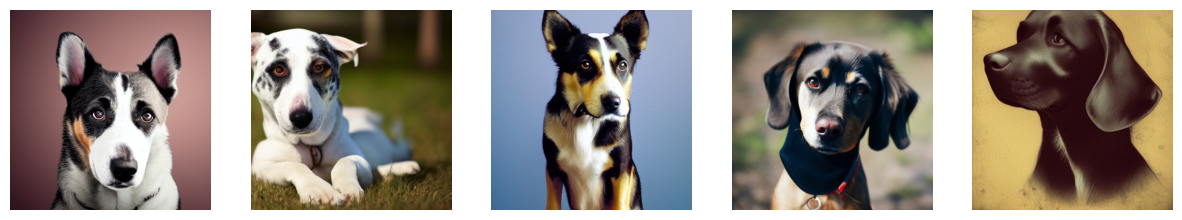

In [19]:
import matplotlib.pyplot as plt

if use_prior_preservation:
    # Create a frozen copy of the original UNet for generating prior samples.
    unet_pretrained = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, 
                                                           subfolder="unet", revision=revision, variant=variant)
    unet_pretrained.to(device, dtype=weight_dtype)
    unet_pretrained.eval()
    
    # Build a separate pipeline using the frozen UNet.
    pipeline_pretrained = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet_pretrained,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None,
    ).to(device)
    
    # Pre-generate a small set of prior samples.
    num_prior_images = 1000  
    prior_latents_list = []
    generated_images = []
    print("Generating prior preservation latents...")
    
    for i in range(num_prior_images):
        print(f"Image №{i}")
        with torch.autocast("cuda"):
            output = pipeline_pretrained(class_prompt, num_inference_steps=50, guidance_scale=7.5)
        gen_image = output.images[0].convert("RGB")
        
        if i < 5:
            generated_images.append(gen_image)
        
        # Convert generated image to tensor.
        gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
        with torch.no_grad():
            latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
        prior_latents_list.append(latent)
    
    # Prepare prior prompt embeddings (to be reused each iteration)
    prior_inputs = tokenizer(class_prompt, return_tensors="pt", max_length=tokenizer.model_max_length,
                             padding="max_length", truncation=True)
    prior_input_ids = prior_inputs["input_ids"].to(device)
    prior_attention_mask = prior_inputs["attention_mask"].to(device)
    with torch.no_grad():
        prior_embeddings = text_encoder(input_ids=prior_input_ids, attention_mask=prior_attention_mask).last_hidden_state

    # Visualize the first five generated images
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx, img in enumerate(generated_images):
        axes[idx].imshow(img)
        axes[idx].axis('off')
    plt.show()

In [58]:
hyperparameters['num_prior_images'] = num_prior_images

In [20]:
# -------------------------------
# 6. Set Up Training Hyperparameters & Optimizer
# -------------------------------
num_train_epochs = 1000
learning_rate = 1e-6

optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(vae.parameters()) + list(text_encoder.parameters()),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

In [60]:
hyperparameters["learning_rate"] = learning_rate 
hyperparameters["num_train_epochs"] = num_train_epochs

In [21]:
# Use total steps based on dataset size (using custom_dataset length)
num_training_steps = num_train_epochs * len(dataset) // train_batch_size
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Create a DataLoader for prior latents
prior_latents_tensor = torch.cat(prior_latents_list, dim=0)

In [ ]:
# torch.save(prior_latents_tensor, '../data/prior_imgs/dog/prior_latents_tensor.pt')

# Load the tensor from the file
loaded_tensor = torch.load('../data/prior_imgs/dog/prior_latents_tensor.pt')

In [ ]:
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=5, shuffle=True)

In [61]:
hyperparameters["prior_batch_size"] = 5

In [23]:
# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    epoch_losses = []

    prior_iter = iter(prior_dataloader)

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device.
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space.
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

        # Sample noise and timesteps for subject images.
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts.
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch.
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss -----
        if use_prior_preservation:
            
            try:
                prior_batch = next(prior_iter)[0].to(device)
            except StopIteration:
                prior_iter = iter(prior_dataloader)
                prior_batch = next(prior_iter)[0].to(device)


            # For the prior branch, sample noise and timesteps.
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                      (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Expand prior embeddings to match batch size.
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch.
            model_pred_prior = unet(noisy_prior_latents, t_prior, encoder_hidden_states=prior_embeddings_expanded,
                                    encoder_attention_mask=prior_attention_mask_expanded, return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + prior_loss_weight * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")

Epochs:   0%|          | 1/1000 [00:00<10:44,  1.55it/s]

Epoch 1/1000, Loss: 0.5652


Epochs:  10%|█         | 101/1000 [00:40<05:59,  2.50it/s]

Epoch 101/1000, Loss: 0.5185


Epochs:  20%|██        | 201/1000 [01:21<05:20,  2.49it/s]

Epoch 201/1000, Loss: 0.2143


Epochs:  30%|███       | 301/1000 [02:01<04:39,  2.50it/s]

Epoch 301/1000, Loss: 0.7635


Epochs:  40%|████      | 401/1000 [02:41<03:58,  2.51it/s]

Epoch 401/1000, Loss: 0.6586


Epochs:  50%|█████     | 501/1000 [03:21<03:19,  2.51it/s]

Epoch 501/1000, Loss: 0.1772


Epochs:  60%|██████    | 601/1000 [04:01<02:39,  2.50it/s]

Epoch 601/1000, Loss: 0.2048


Epochs:  70%|███████   | 701/1000 [04:41<01:59,  2.50it/s]

Epoch 701/1000, Loss: 0.5836


Epochs:  80%|████████  | 801/1000 [05:21<01:21,  2.45it/s]

Epoch 801/1000, Loss: 0.0621


Epochs:  90%|█████████ | 901/1000 [06:01<00:39,  2.50it/s]

Epoch 901/1000, Loss: 0.0473


Epochs: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


In [ ]:
# import json
# # Save the dictionary to a JSON file
# with open('../data/experiments_params/hyperparameters.json', 'w') as f:
#     json.dump(hyperparameters, f)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/100 [00:00<?, ?it/s]

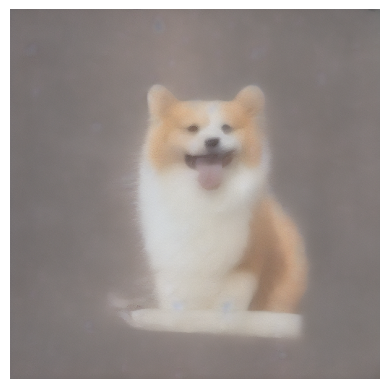

In [69]:
# -------------------------------
# 8. Inference: Generate Images using the Fine-Tuned Model
# -------------------------------
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

# Use a prompt with the unique subject identifier to generate subject images.
prompt = subject_prompt + " in a car"
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"generated_image_{idx}.png")


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/100 [00:00<?, ?it/s]

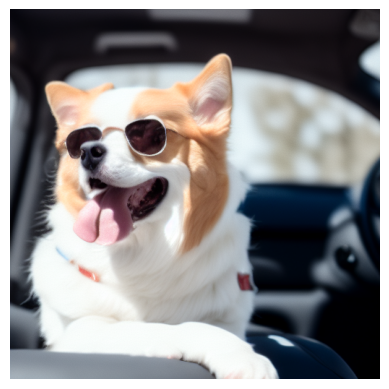

In [76]:
# -------------------------------
# 8. Inference: Generate Images using the Fine-Tuned Model
# -------------------------------
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)

pipeline = pipeline.to(device)

# Use a prompt with the unique subject identifier to generate subject images.
prompt = subject_prompt
prompt = "a hul () dog" + 'in the car'
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img.save(f"styled_generated_image_{idx}.png")


In [54]:
pipeline.save_pretrained('../data/models/pipeline_v1')